## **DSC 180AB Data Science Capstone**
### Replication Project

**Team Members**:


*   Chester (Kai) Ni
*   Catherine Back
*   Yuancheng (Kaleo) Cao
*   Kavya Sriram



### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms. It also demonstrates how explanations can be generated for predictions made by models learnt with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components:
* Household
* Insurance/Employer, and
* Medical Provider.

These components provide comprehensive national estimates of health care use and payment by individuals, families, and any other demographic group of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 documentation is available [here](https://aif360.readthedocs.io/en/stable/).

The AI Fairness 360 package includes:
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classifier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions be not predicated on factors such as race of the patient.
* Developer takes the model AND performance characteristics / specs of the model (e.g. accuracy, fairness tests, etc. basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations.
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness is communicated to AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is sent back for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015).
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

#### 1.3 Methodology

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management.
* Initial deployment is simulated to 2015 Panel 20 deployment data.
* To show change in performance and/or fairness over time, the 2016 Panel 21 deployment data is used.
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data

### 1.4 Insert writeup of overall replication project goals and big picture thinking (2-3 paragraphs).  
* **Why do we care about this?**
We care because this data can be used to explore trends and patterns in medicine and hospitals. It can help better our understanding in matters of health and relationships between diagnoses as well as provide more insight on overhead such as insurance coverage and hospital stays. If you factor in the different demographics in this data the information is very useful to the medical industry as it can enhance decision making in matters of health and administration.
* **What would the benefit of predicting utilization be?**
The benefit of predicting utilization could be improved decision making as well as more proactive behaviors rather than preventative which in the case of healthcare can be very essential. If you have an idea about who the diagnosis  of one disease can possibly be an indicator of another you can take preventative action and potentially improve the situation. Also it can shed light on other details regarding demographics and possible inequality of care which can also be combatted proactively.
* **What might occur if there are errors?**
Errors can be detrimental because in matters of health a wrong or missed diagnosis can be very serious. Also demographic mistakes can also be harmful as sometimes those can be key indicators to health issues along with other details. Also error in handling the data can lead to serious privacy violations which can also have major consequences.
* **Who are the affected parties and stakeholders?**
The affected parties and stakeholders are both patients and members of the healthcare industry, such as doctors. This is because the patient's health and data are at stake and can be affected by this exploration. Members of the healthcare industry are relevant because it is their job to properly utilize predictions and insights found to improve performance and experience for healthcare patients.
* **Other thoughts?**
The insights found from this data need to be very thoroughly checked as when it comes to health things aren’t very cut and dry. There are a lot of nuances and different meanings when it comes to health conditions and diagnoses that need to be considered before applying what is learned from the data.

---
End of Introduction

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015).
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project.

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

**Before Proceeding Ensure You Have:**
* Forked the AIF360 repository and cloned locally to your disk or virtual machine
* Downloaded the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` in a folder you can access (we placed it in `../aif360/data/raw/meps/` of our forked AIF360 repository)
* For EDA we only focus on `h181.csv`

In [1]:
!pip install aif360
!pip install 'aif360[all]'

In [2]:
# Imports
import sys


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression


2024-11-03 08:22:26.520161: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/aif360/lib/python3.11/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [3]:
raw_181 = pd.read_csv('aif360/data/raw/meps/h181.csv')
raw_192 = pd.read_csv('aif360/data/raw/meps/h192.csv')

In [4]:
raw_181

,DUID,PID,DUPERSID,PANEL,FAMID31,FAMID42,FAMID53,FAMID15,FAMIDYR,CPSFAMID,...,RXOSR15,RXPTR15,RXOTH15,PERWT15F,FAMWT15F,FAMWT15C,SAQWT15F,DIABW15F,VARSTR,VARPSU
0,60001,101,60001101,19,A,A,A,A,A,A,...,0,0,0,21854.981705,22983.493815,22983.493815,23226.272970,26185.048789,1019,1
1,60001,102,60001102,19,A,A,A,A,A,B,...,0,0,4,18169.604822,22983.493815,14663.337957,20624.450027,22682.689497,1019,1
2,60001,103,60001103,19,A,A,A,A,A,B,...,0,0,0,23812.596388,22983.493815,14663.337957,31246.723516,0.000000,1019,1
3,60001,104,60001104,19,A,A,A,A,A,C,...,0,0,0,17191.832515,22983.493815,11200.744542,18125.280372,0.000000,1019,1
4,60001,105,60001105,19,A,A,A,A,A,C,...,0,0,265,20261.485463,22983.493815,11200.744542,0.000000,0.000000,1019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,80569,108,80569108,20,B,A,D,D,A,A,...,0,0,0,2812.010290,2449.173357,2449.173357,0.000000,0.000000,1056,2
35423,80570,101,80570101,20,A,A,A,A,A,A,...,0,1248,0,11481.496934,13076.665735,13076.665735,11648.039744,0.000000,1126,1
35424,80571,101,80571101,20,A,A,A,A,A,A,...,0,0,0,8357.376060,7085.589291,7085.589291,9920.807391,0.000000,1144,1
35425,80571,102,80571102,20,A,A,A,A,A,A,...,0,1230,0,8389.102961,7085.589291,7085.589291,9141.136948,0.000000,1144,1


#### Apply pre-processing scripts

In [5]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [6]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [7]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts,
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [8]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [9]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

**END OF PRE-PROCRESSING**


#### 2.2 Data shape and features

In [10]:
df_panel_19_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
0,2,53,1,White,5,-1,2,2,4,3,...,2,25.93,58.47,3,0,4,1,2,1,21854.981705
1,2,56,2,White,3,-1,2,2,4,3,...,2,20.42,26.57,17,6,4,3,2,1,18169.604822
3,2,23,2,White,5,3,2,2,1,1,...,2,53.12,50.33,7,0,1,2,2,0,17191.832515
4,2,3,1,White,6,-1,3,3,1,3,...,-1,-1.00,-1.00,-1,-1,-1,2,2,0,20261.485463
5,3,27,1,Non-White,1,-1,1,4,2,1,...,-1,-1.00,-1.00,-1,-1,1,3,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,3,25,1,Non-White,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,1,1,1,0,4111.315754
16574,3,25,2,Non-White,1,-1,2,2,1,1,...,2,56.71,62.39,0,0,4,1,1,0,5415.228173
16575,3,2,2,White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,3896.116219
16576,1,54,2,Non-White,3,-1,2,2,1,1,...,2,43.97,42.45,24,0,1,3,2,0,4883.851005


In [11]:
df_panel_20_reduced

,REGION,AGE,SEX,RACE,MARRY,FTSTU,ACTDTY,HONRDC,RTHLTH,MNHLTH,...,ADSMOK42,PCS42,MCS42,K6SUM42,PHQ242,EMPST,POVCAT,INSCOV,UTILIZATION,PERWT15F
16578,3,65,1,Non-White,1,-1,4,1,3,3,...,2,39.15,64.23,1,1,1,4,1,0,11966.862856
16579,3,57,2,Non-White,1,-1,2,2,3,3,...,2,23.61,48.28,5,3,4,4,1,1,10300.188631
16580,4,40,1,Non-White,1,-1,2,2,3,3,...,2,53.97,52.82,4,0,1,5,1,0,18749.279706
16581,3,55,2,Non-White,5,-1,2,2,3,3,...,1,40.50,61.61,0,0,1,2,2,0,5532.628347
16582,3,21,2,Non-White,5,1,2,2,3,3,...,-1,-1.00,-1.00,-1,-1,4,2,3,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35422,3,8,1,Non-White,6,-1,3,3,1,1,...,-1,-1.00,-1.00,-1,-1,-1,1,2,0,2812.010290
35423,2,30,2,Non-White,5,-1,2,2,3,2,...,2,44.32,28.41,7,2,1,3,1,1,11481.496934
35424,3,32,1,Non-White,1,-1,2,2,3,2,...,2,36.80,61.23,1,0,1,5,1,0,8357.376060
35425,3,32,2,Non-White,1,-1,2,2,2,2,...,2,56.48,47.77,1,0,1,5,1,0,8389.102961


### **Data Overview and Feature Summary of `df_panel_19_reduced`**

In [12]:
# identify feature names (columns)
feature_names = df_panel_19_reduced.columns.tolist()
print("Feature Names: ", feature_names)

Feature Names:  ['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC', 'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN', 'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM', 'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV', 'UTILIZATION', 'PERWT15F']


Feature Names | Definition/Explanation
--|--
REGION | Census region; 1:Northeast, 2:Midwest, 3:South, 4:West
FTSTU | Student status
ACTDTY | Active duty
HONRDC | Honorable discharge
RTHLTH | Perceived health status
MNHLTH | Perceived mental health status
HIBPDX | High blood pressure
CHDDX | Asked if ever diagnosed with coronary heart disease
ANGIDX | Asked if ever diagnosed with angina or angina pectoris
MIDX | Asked if ever diagnosed with heart attack or myocardial infraction
OHRTDX | Asked if ever diagnosed with any kind of heart disease or condition
STRKDX | Asked if ever diagnosed with a stroke or transient ischemic attack
EMPHDX | Asked if ever diagnosed with emphysema
CHBRON | Asked if had chronic bronchitis in last 12 months
CHOLDX | Asked if ever diagnosed with high cholesterol
CANCERDX | Asked if ever diagnosed with cancer or malignancy of any kind
DIABDX | Asked if ever diagnosed with diabetes
JTPAIN | Asked if had pain, swelling, or stiffness around a joint in last 12 months
ARTHDX | Asked if ever diagnosed with arthritis
ARTHTYPE | Arthritis Type; 1:Rheumatoid, 2: Osteoarthritis, 3:Non-specific
ASTHDX | Asked if ever diagnosed with asthma
ADHDADDX | Asked if ever diagnosed with ADHD or ADD
WLKLIM | Walking limitations
ACTLIM | Work, housework, and school limitations
SOCLIM | Social limitations
COGLIM | Cognitive limitations
DFHEAR42 | Difficulty hearing
DFSEE42 | Difficulty seeing
ADSMOK42 | Currently smokes
K6SUM42 | Kessler Index for non-specific, rather than disorder-specific, psychological distress: 0 None of the Time 1 A Little of the Time 2 Some of the Time 3 Most of the Time 4 All of the Time
PHQ242 | Summation of two variables: ADINTR42 – During the past two weeks, bothered by having little interest or pleasure in doing things, ADDPRS42 – During the past two weeks, bothered by feeling down, depressed, or hopeless
EMPST | Employment status
POVCAT | Poverty status
INSCOV | Health insurance coverage; 1:private, 2:public, 3:uninsured

In [13]:
# check for categorical features
categorical_features = df_panel_19_reduced.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Features: ", categorical_features)

Categorical Features:  ['RACE']


In [14]:
# summary statistics for numerical and catgeorical features
summary_stats = df_panel_19_reduced.describe(include='all')
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
               REGION           AGE           SEX       RACE         MARRY  \
count   15830.000000  15830.000000  15830.000000      15830  15830.000000   
unique           NaN           NaN           NaN          2           NaN   
top              NaN           NaN           NaN  Non-White           NaN   
freq             NaN           NaN           NaN      10174           NaN   
mean        2.825584     35.090461      1.521162        NaN      3.661213   
std         1.002033     22.475549      0.499568        NaN      2.121255   
min         1.000000      0.000000      1.000000        NaN      1.000000   
25%         2.000000     15.000000      1.000000        NaN      1.000000   
50%         3.000000     33.000000      2.000000        NaN      5.000000   
75%         4.000000     53.000000      2.000000        NaN      6.000000   
max         4.000000     85.000000      2.000000        NaN     10.000000   

               FTSTU        ACTDTY        HONRDC      

In [15]:
# shape of the dataset
print("Shape of df_panel_19_reduced: ", df_panel_19_reduced.shape)

Shape of df_panel_19_reduced:  (15830, 43)


#### 2.3 Outlier Detection and Handling

In [16]:
#Handling Missing Values and Not Applicable Values

#Missing Values
missing_values = df_panel_19_reduced.isnull().sum()
print(missing_values[missing_values > 0]) #There are no columns that have missing values

# Not Applicable Values
df_panel_19_numeric = df_panel_19_reduced.apply(pd.to_numeric, errors='coerce')

# Now check for values less than or equal to 0
check_na = df_panel_19_numeric < 0

# Count how many such values exist in each column
na_count = check_na.sum()

# Display columns that have any negative values or zero
# print(na_count[na_count > 0])

df_panel_19_numeric[df_panel_19_numeric < 0] = -1

# Display columns that have any negative values or zero
print(na_count[na_count > 0])


Series([], dtype: int64)
FTSTU       14316
RTHLTH         18
MNHLTH         18
HIBPDX       4474
CHDDX        4474
ANGIDX       4474
MIDX         4474
OHRTDX       4474
STRKDX       4474
EMPHDX       4474
CHBRON       4490
CHOLDX       4474
CANCERDX     4474
DIABDX       4474
JTPAIN       4490
ARTHDX       4474
ARTHTYPE    12893
ADHDADDX    12022
PREGNT      12568
WLKLIM         18
ACTLIM       1086
SOCLIM         18
COGLIM       4490
DFHEAR42      357
DFSEE42       357
ADSMOK42     6235
PCS42        6286
MCS42        6280
K6SUM42      6410
PHQ242       6235
EMPST        3976
dtype: int64


In [17]:
# Applying One Hot Encoding and ignores columns that are numerical
df_panel_19_onehot = pd.get_dummies(df_panel_19_numeric, dtype=int, columns=[col for col in df_panel_19_numeric.columns if not col in ['AGE', 'PCS42','MCS42', 'PHQ242', 'PERWT15F', 'UTILIZATION']])
df_panel_19_onehot

,AGE,PCS42,MCS42,PHQ242,UTILIZATION,PERWT15F,REGION_1,REGION_2,REGION_3,REGION_4,...,EMPST_3,EMPST_4,POVCAT_1,POVCAT_2,POVCAT_3,POVCAT_4,POVCAT_5,INSCOV_1,INSCOV_2,INSCOV_3
0,53,25.93,58.47,0,1,21854.981705,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0
1,56,20.42,26.57,6,1,18169.604822,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
3,23,53.12,50.33,0,0,17191.832515,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,3,-1.00,-1.00,-1,0,20261.485463,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
5,27,-1.00,-1.00,-1,0,0.000000,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,25,56.71,62.39,0,0,4111.315754,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
16574,25,56.71,62.39,0,0,5415.228173,0,0,1,0,...,0,1,1,0,0,0,0,1,0,0
16575,2,-1.00,-1.00,-1,0,3896.116219,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
16576,54,43.97,42.45,0,0,4883.851005,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


#### 2.4 Correlation Analysis

<Figure size 3000x2500 with 0 Axes>

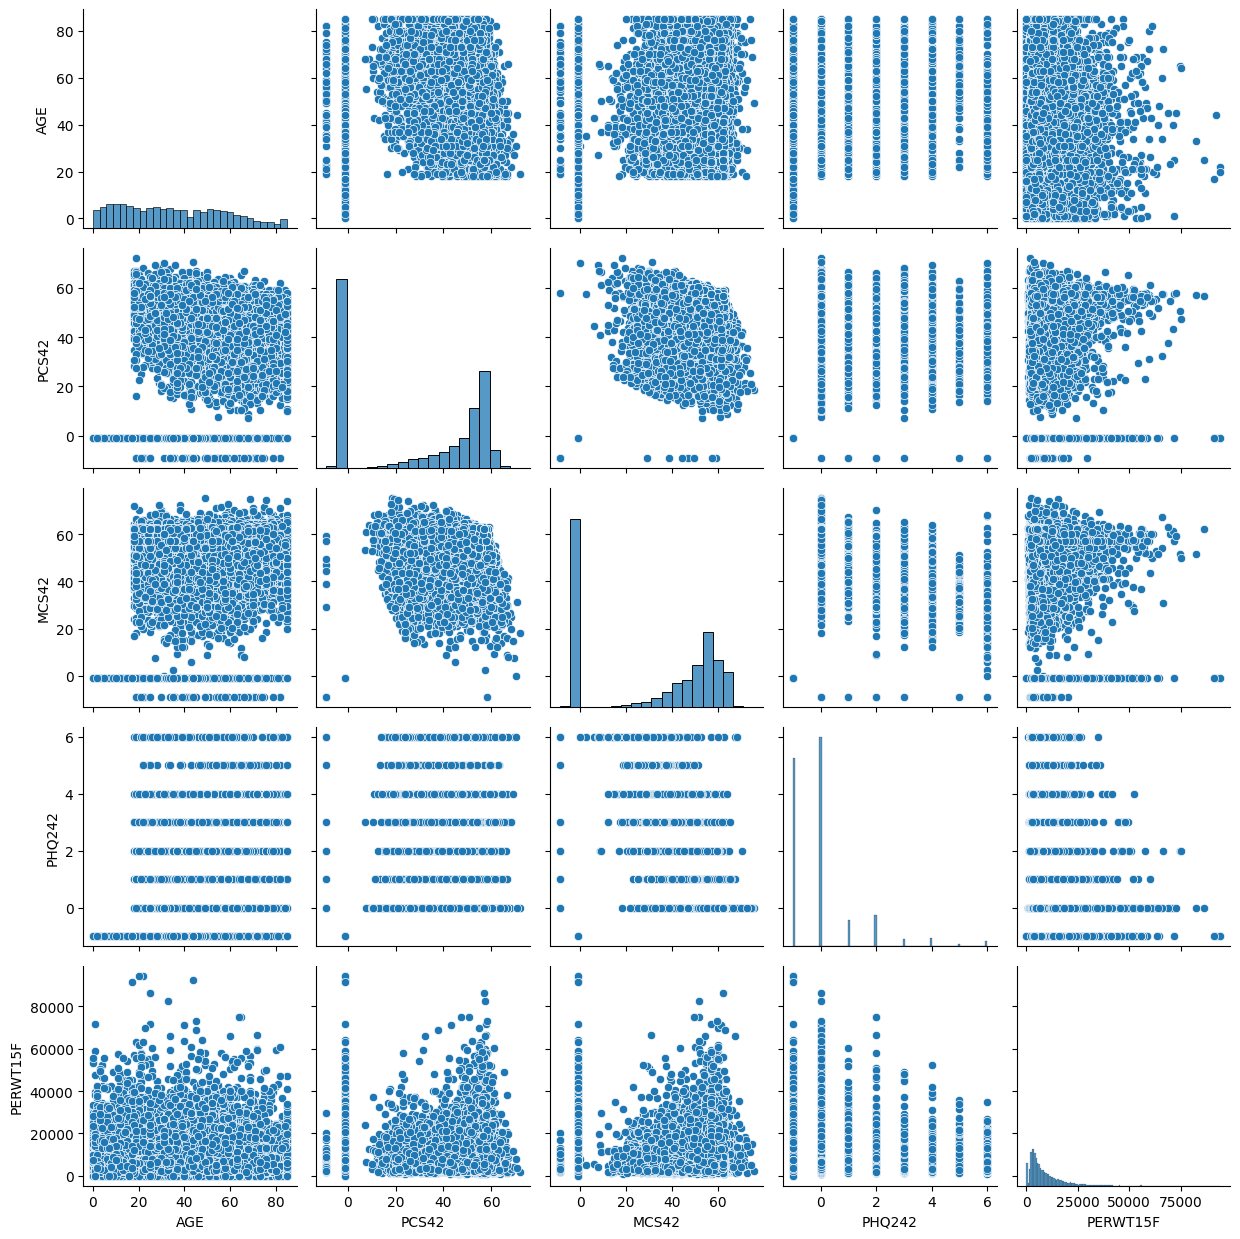

In [18]:
# Preliminary data visualizations
# Correlation plots
plt.figure(figsize=(30,25))
corr = df_panel_19_onehot.select_dtypes(include='number').corr()
df_panel_19_corr = df_panel_19_reduced[['AGE', 'PCS42','MCS42', 'PHQ242', 'PERWT15F']].copy()
sns.pairplot(df_panel_19_corr)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
corr['UTILIZATION'].sort_values(ascending=False)


UTILIZATION    1.000000
WLKLIM_1       0.370146
ARTHDX_1       0.362279
ACTLIM_1       0.353689
AGE            0.337893
                 ...   
ADSMOK42_-1   -0.207257
ACTLIM_2      -0.217069
SOCLIM_2      -0.275891
ARTHTYPE_-1   -0.362279
WLKLIM_2      -0.371547
Name: UTILIZATION, Length: 157, dtype: float64

In [20]:
corr_series = corr.unstack()
corr_series = corr_series[corr_series.index.get_level_values(0) != corr_series.index.get_level_values(1)]
corr_series = corr_series.drop_duplicates()

top_10_corr = corr_series.nlargest(20)
bottom_10_corr = corr_series.nsmallest(20)

top_10_df = pd.DataFrame({
    'col1': top_10_corr.index.get_level_values(0),
    'col2': top_10_corr.index.get_level_values(1),
    'corr': top_10_corr.values
})

bottom_10_df = pd.DataFrame({
    'col1': bottom_10_corr.index.get_level_values(0),
    'col2': bottom_10_corr.index.get_level_values(1),
    'corr': bottom_10_corr.values
})

print(top_10_df)

print(bottom_10_df)

           col1        col2      corr
0       MARRY_6    ACTDTY_3  1.000000
1     HIBPDX_-1   CHBRON_-1  0.997513
2     CHBRON_-1   CHOLDX_-1  0.997513
3   ADSMOK42_-1  K6SUM42_-1  0.977220
4      HONRDC_3   HIBPDX_-1  0.961137
5       MARRY_6    HONRDC_3  0.959997
6      HONRDC_3    EMPST_-1  0.959997
7      HONRDC_3   CHBRON_-1  0.958747
8      EMPHDX_2    CHBRON_2  0.952128
9      ANGIDX_2      MIDX_2  0.937940
10     ANGIDX_2    EMPHDX_2  0.937930
11     ANGIDX_2    CHBRON_2  0.937628
12      CHDDX_2      MIDX_2  0.936434
13        PCS42       MCS42  0.924988
14      MARRY_6   HIBPDX_-1  0.922689
15    HIBPDX_-1    EMPST_-1  0.922689
16      CHDDX_2    ANGIDX_2  0.921900
17       MIDX_2    CHBRON_2  0.921867
18       MIDX_2    EMPHDX_2  0.921867
19      MARRY_6   CHBRON_-1  0.920395
         col1         col2      corr
0    ARTHDX_1  ARTHTYPE_-1 -1.000000
1    ASTHDX_1     ASTHDX_2 -1.000000
2       SEX_1        SEX_2 -1.000000
3    WLKLIM_1     WLKLIM_2 -0.993506
4    SOCLIM_1    

#### 2.5 Other analysis

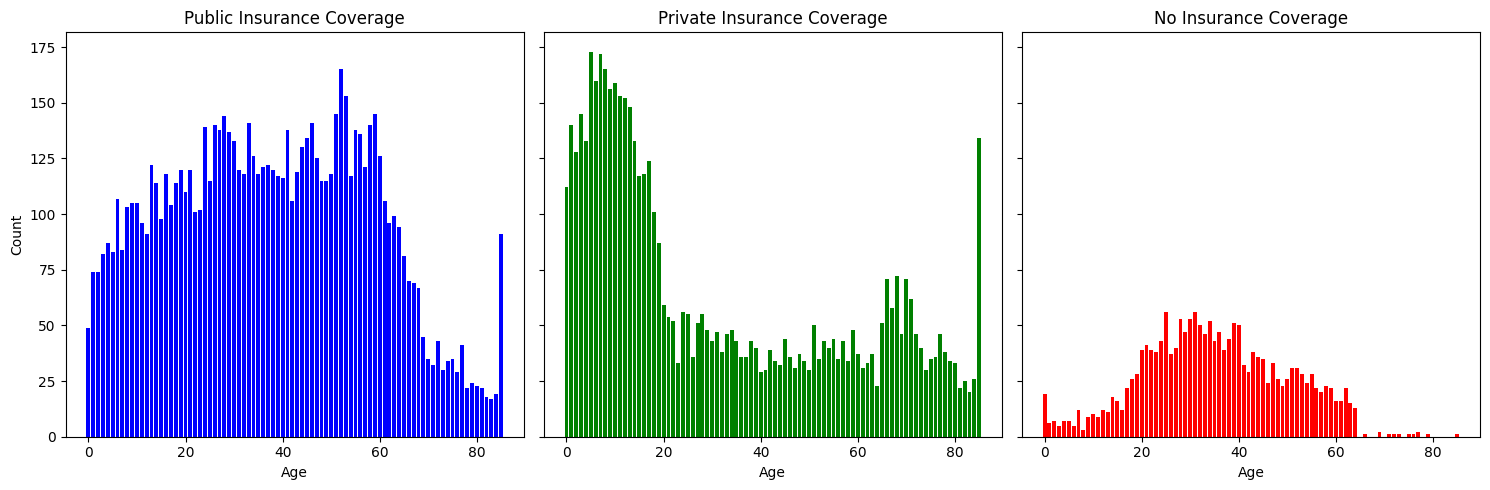

In [21]:
### Create three different barplots that show the trend of health insurance coverage overtime.

# Filter data for each INSCOV value
inscov_1 = df_panel_19_reduced[df_panel_19_reduced['INSCOV'] == 1]
inscov_2 = df_panel_19_reduced[df_panel_19_reduced['INSCOV'] == 2]
inscov_3 = df_panel_19_reduced[df_panel_19_reduced['INSCOV'] == 3]

# Group by AGE and get counts
inscov_1_counts = inscov_1['AGE'].value_counts().sort_index()
inscov_2_counts = inscov_2['AGE'].value_counts().sort_index()
inscov_3_counts = inscov_3['AGE'].value_counts().sort_index()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Barplot for INSCOV = 1 with color palette
axs[0].bar(inscov_1_counts.index, inscov_1_counts.values, color = 'blue')
axs[0].set_title('Public Insurance Coverage')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Count')

# Barplot for INSCOV = 2 with color palette
axs[1].bar(inscov_2_counts.index, inscov_2_counts.values, color = 'green')
axs[1].set_title('Private Insurance Coverage')
axs[1].set_xlabel('Age')

axs[2].bar(inscov_3_counts.index, inscov_3_counts.values, color = 'red')
axs[2].set_title('No Insurance Coverage')
axs[2].set_xlabel('Age')

plt.tight_layout()
plt.show()

We observe in these bar plots that there are different trends in the type of insurance each age group has. Public insurance slowly increases as the age increases, but there is a decline around the age of 70. Private insurance is the highest in ages below and around 20, and there is a sharp decline around the age of 26. The last barplot shows the trend in age for those with no health insurance, and we see a decline at the age of 65. 

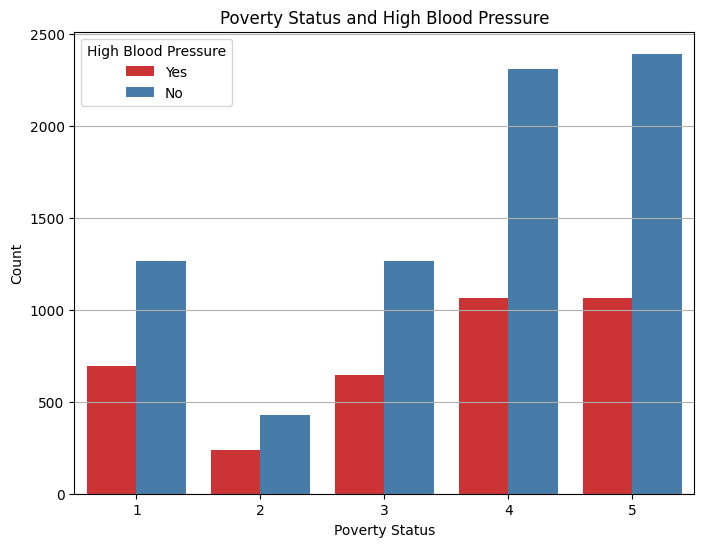

In [22]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_panel_19_reduced[df_panel_19_reduced['HIBPDX'] > 0], x='POVCAT', hue='HIBPDX', palette='Set1')
plt.title('Poverty Status and High Blood Pressure')
plt.xlabel('Poverty Status')
plt.ylabel('Count')
plt.legend(title='High Blood Pressure', labels=['Yes', 'No'])
plt.grid(axis='y')
plt.show()

We observed that the Poverty Levels of 4 and 5 which indicate that they are well off, have the lowest percent of high blood pressure when compared to those that do. The poverty level indicated as 1 and 2 which indicate poor have the highest percentage of high blood pressure.

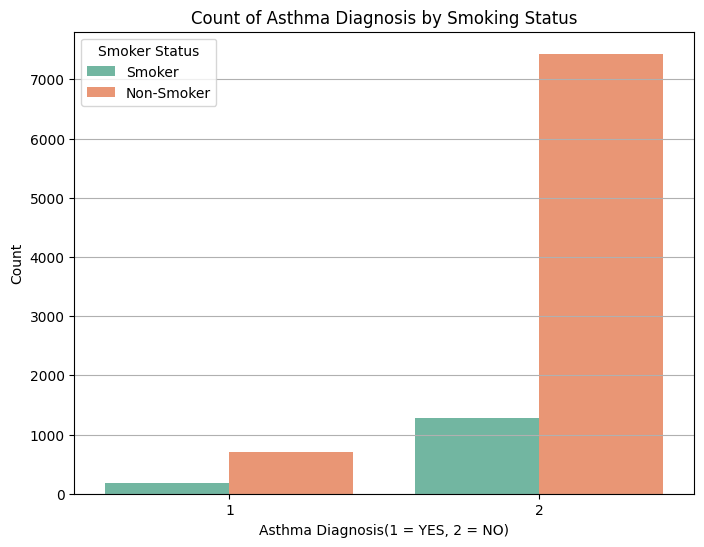

Correlation between asthma and smoking: 0.033689069040909105


In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_panel_19_reduced[df_panel_19_reduced['ADSMOK42'] > 0], x='ASTHDX', hue='ADSMOK42', palette='Set2')
plt.title('Count of Asthma Diagnosis by Smoking Status')
plt.xlabel('Asthma Diagnosis(1 = YES, 2 = NO)')
plt.ylabel('Count')
plt.legend(title='Smoker Status', labels=['Smoker', 'Non-Smoker'])
plt.grid(axis='y')
plt.show()

df_filtered = df_panel_19_onehot[['ASTHDX_1', 'ADSMOK42_1']]
correlation = df_filtered.corr()['ASTHDX_1']['ADSMOK42_1']

print("Correlation between asthma and smoking:", correlation)


We observed there is no strong correlation between smoking and having asthma. A majority of the participants don't smoke and don’t have asthma.

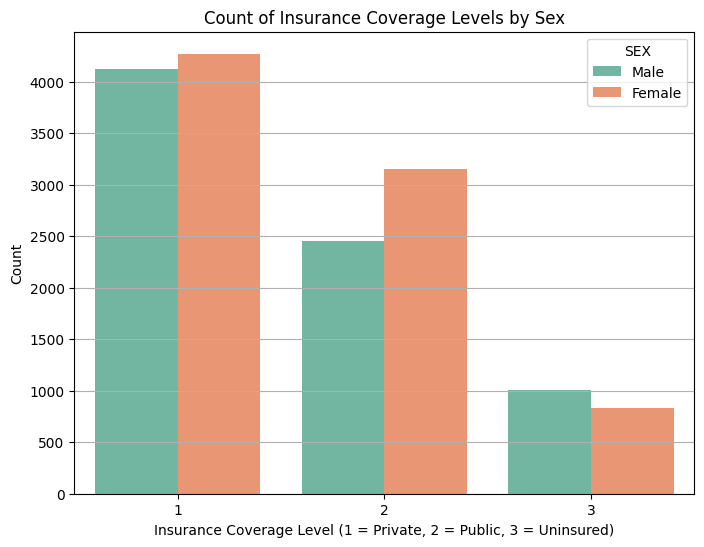

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_panel_19_reduced, x='INSCOV', hue='SEX', palette='Set2')
plt.title('Count of Insurance Coverage Levels by Sex')
plt.xlabel('Insurance Coverage Level (1 = Private, 2 = Public, 3 = Uninsured)')
plt.legend(title='SEX', labels=['Male', 'Female'])
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

Men seem to have less insurance coverage than women (more frequently uninsured) while public and private insurance seem to have a similar balance of slightly more women having either type of insurance than men.

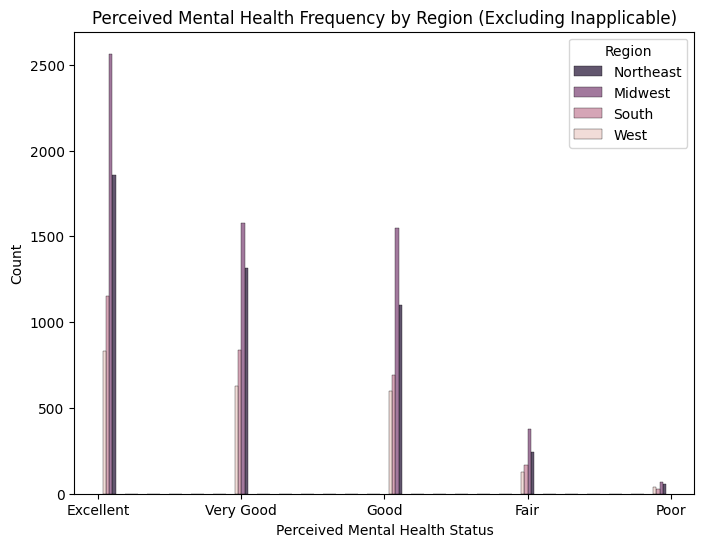

In [25]:
# Creating a boxplot to show perceived mental health by region

df_MNHLTH_filtered = df_panel_19_numeric[df_panel_19_numeric['MNHLTH'] != -1]

plt.figure(figsize=(8, 6))
sns.histplot(data=df_MNHLTH_filtered, x='MNHLTH', hue='REGION', multiple="dodge",shrink=0.6)
plt.title('Perceived Mental Health Frequency by Region (Excluding Inapplicable)')
plt.xlabel('Perceived Mental Health Status')
plt.ylabel('Count')
plt.xticks([1, 2, 3, 4, 5], ['Excellent', 'Very Good', 'Good', 'Fair', 'Poor'])
plt.legend(title='Region', labels=['Northeast', 'Midwest', 'South', 'West'])
plt.show()

Health Frequency by Region (Excluding Inapplicable)' graph, the Midwest region shows the highest perceived mental health frequency in the 'excellent,' 'very good,' and 'good' categories, followed by the Northeast, South, and West, respectively. In the 'poor' category, all regions have an equal distribution.

Description: In the Perceived Mental Health Frequency by Region (Excluding Inapplicable) graph, midwest  

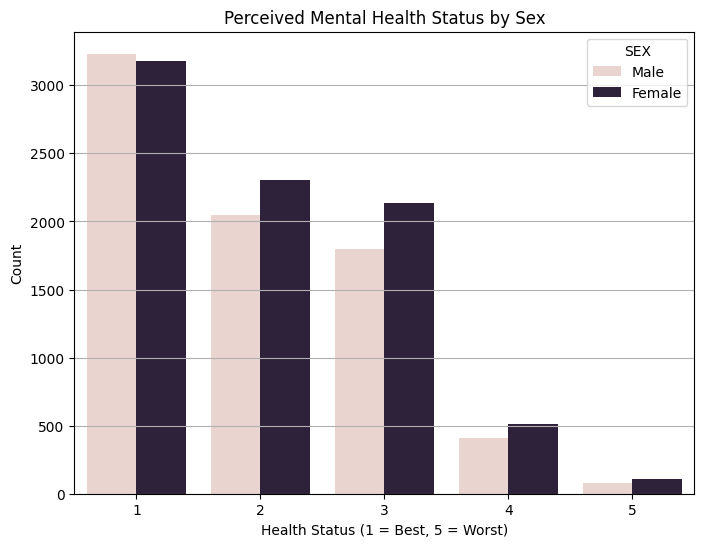

In [26]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_panel_19_reduced[df_panel_19_reduced['MNHLTH']>0], x='MNHLTH', hue='SEX')
plt.title('Perceived Mental Health Status by Sex')
plt.xlabel('Health Status (1 = Best, 5 = Worst)')
plt.ylabel('Count')
plt.legend(title='SEX', labels=['Male', 'Female'])
plt.grid(axis='y')
plt.show()

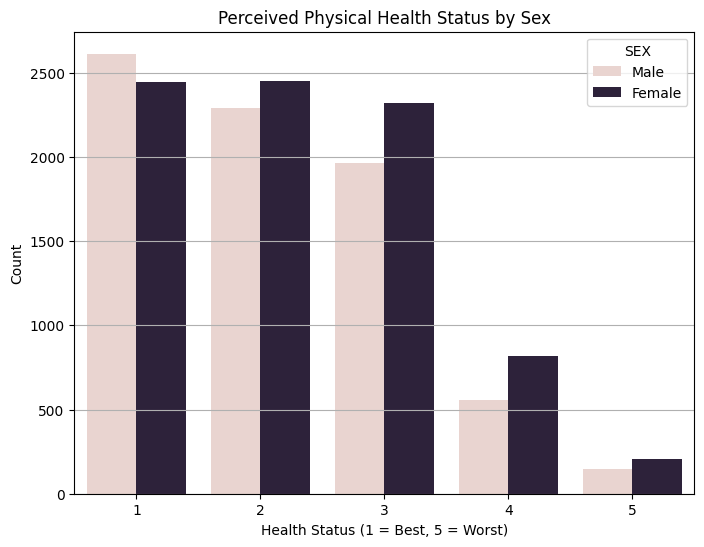

In [27]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_panel_19_reduced[df_panel_19_reduced['RTHLTH']>0], x='RTHLTH', hue='SEX')
plt.title('Perceived Physical Health Status by Sex')
plt.xlabel('Health Status (1 = Best, 5 = Worst)')
plt.ylabel('Count')
plt.legend(title='SEX', labels=['Male', 'Female'])
plt.grid(axis='y')
plt.show()

For both mental and physical health, there appear to be a roughly even number of males and females perceived at the best quality of health. However, for both mental and physical health, a larger portion of females appear to be perceived as having a lower quality of health than males. This metric specifically observes **perceived** health, this distinction could potentially be due to a general bias causing females in general to be perceived as having worse health compared to males.

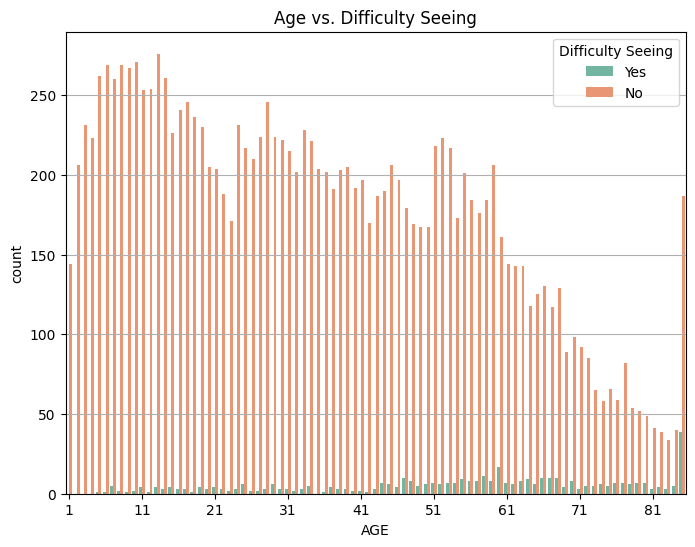

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_panel_19_reduced[df_panel_19_reduced['DFSEE42'] > 0], x='AGE', hue='DFSEE42', palette='Set2')
plt.grid(axis='y')
plt.title('Age vs. Difficulty Seeing')
plt.legend(title='Difficulty Seeing', labels=['Yes', 'No'])
plt.xticks(ticks=range(0, df_panel_19_reduced['AGE'].max() + 1, 10))
plt.show()

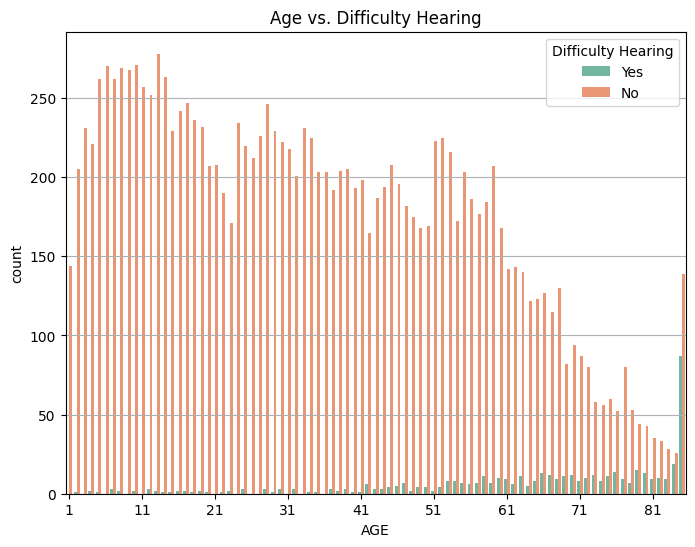

In [29]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_panel_19_reduced[df_panel_19_reduced['DFHEAR42'] > 0], x='AGE', hue='DFHEAR42', palette='Set2')
plt.grid(axis='y')
plt.title('Age vs. Difficulty Hearing')
plt.legend(title='Difficulty Hearing', labels=['Yes', 'No'])
plt.xticks(ticks=range(0, df_panel_19_reduced['AGE'].max() + 1, 10))
plt.show()

We observed that as age increases, more people report difficulty hearing and seeing. 

### Insurance Coverage and Insurance Utilization
We wanted to see the breakdown distribution of the insurance coverage levels and utilization. The reason for this is that different insurance coverage might influence the amount of utilization a person would have. After analyzing the heatmap, it is clear that there is more data with low insurance utilization overall. Those with high utilization and no health insurance are disproportionately lower compared to other sections. 

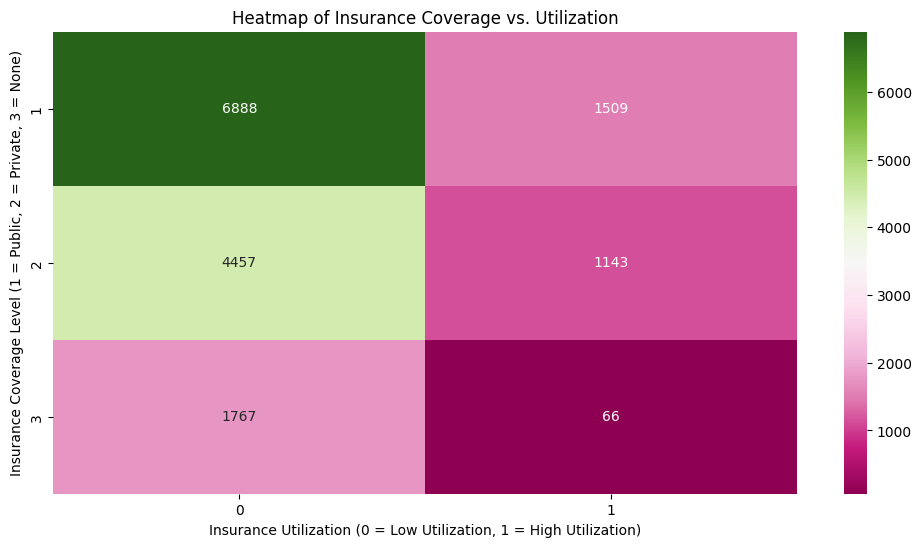

In [61]:
#Heat Map for Insurance Coverage and Insurance Utilization
heatmap_data = df_panel_19_reduced.pivot_table(index='INSCOV', columns='UTILIZATION', aggfunc='size', fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='PiYG')
plt.title('Heatmap of Insurance Coverage vs. Utilization')
plt.xlabel('Insurance Utilization (0 = Low Utilization, 1 = High Utilization)')
plt.ylabel('Insurance Coverage Level (1 = Public, 2 = Private, 3 = None)')
plt.show()

### Box Plot of Age by Utilization
We wanted to see the breakdown of Utilization by age within the dataset. The reason for this is that it is expected for the utilization to increase as age increase, so we wanted to confirm that this trend is seen in this dataset. As expected we see that the average age for low utilization is around 30, while the average age for high utilization is late 50's. 

/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_46014/1745485197.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='UTILIZATION', y='AGE', data=df_panel_19_reduced, palette='Accent')


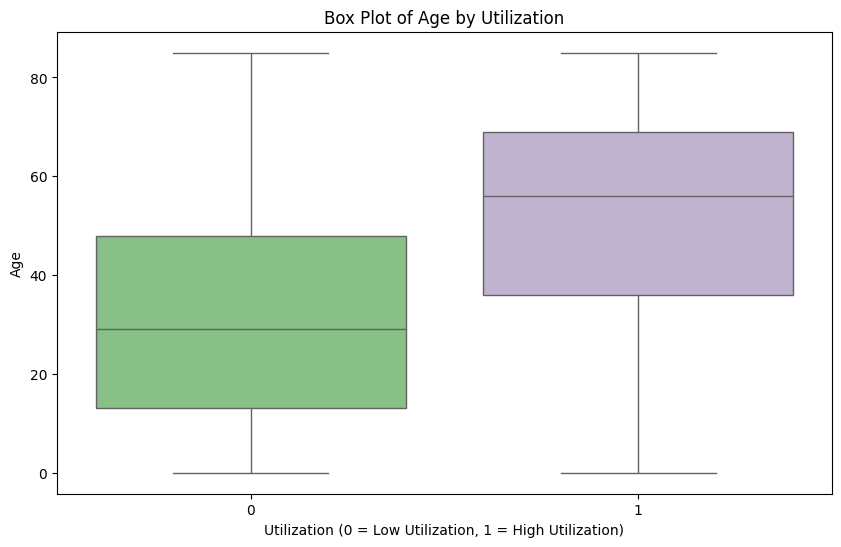

In [62]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='UTILIZATION', y='AGE', data=df_panel_19_reduced, palette='Accent')
plt.title('Box Plot of Age by Utilization')
plt.xlabel('Utilization (0 = Low Utilization, 1 = High Utilization)')
plt.ylabel('Age')
plt.show()

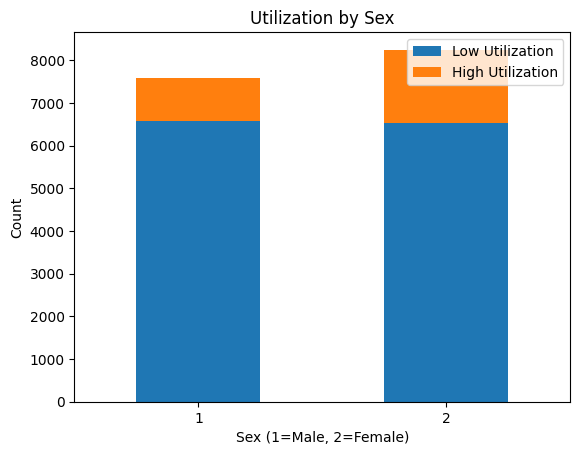

In [63]:
grouped_data = df_panel_19_reduced.groupby(['SEX', 'UTILIZATION']).size().unstack().fillna(0)

fig, ax = plt.subplots()
grouped_data.plot(kind='bar', stacked=True, ax=ax)
ax.set_title("Utilization by Sex")
ax.set_xlabel("Sex (1=Male, 2=Female)")
ax.set_ylabel("Count")
ax.legend(["Low Utilization", "High Utilization"])
plt.xticks(rotation=0)
plt.show()

/var/folders/fy/20h6tjtj0lb6vgm0w4qt4m2c0000gn/T/ipykernel_46014/2809756450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_panel_19_reduced['HEALTH_MEAN'] = (df_panel_19_reduced['MNHLTH'] + df_panel_19_reduced['RTHLTH']) / 2


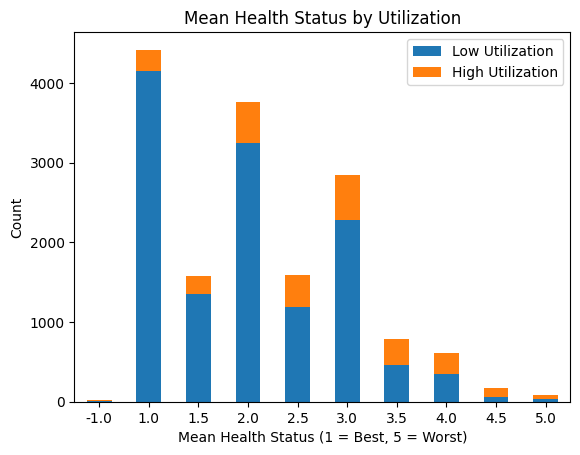

In [64]:
df_panel_19_reduced['HEALTH_MEAN'] = (df_panel_19_reduced['MNHLTH'] + df_panel_19_reduced['RTHLTH']) / 2

grouped_health_utilization = df_panel_19_reduced.groupby(['HEALTH_MEAN', 'UTILIZATION']).size().unstack().fillna(0)

fig, ax = plt.subplots()
grouped_health_utilization.plot(kind='bar', stacked=True, ax=ax)
ax.set_title("Mean Health Status by Utilization")
ax.set_xlabel("Mean Health Status (1 = Best, 5 = Worst)")
ax.set_ylabel("Count")
ax.legend(["Low Utilization", "High Utilization"])
plt.xticks(rotation=0)
plt.show()

-----
End of Exploratory Data Analysis

-----
# **Start of Replication Part 02 -  Model Development, and Fairness Evaluation**

### There are **two** components to `Replication Project Part #02`
1. Training models without de-biasing, using IBM's tutorial
2. Training models without de-biasing, using your own model development techniques including (1) Feature Selection, (2) Encoding, (3) Binning Features, and other items

#### We will now return to IBM AIF360's [Medical Expenditure Tutorial](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb)
_*Note that it is primarily Scikit-learn based_

* A reminder, you will need to fork [AIF360's repository](https://github.com/Trusted-AI/AIF360) into your own GitHub and access the notebook locally or via your method of choice
* AIF360's Repository can be found under: `AIF360`/`Examples`/tutorial_medical_expenditure.ipynb
* Ensure you have your `aif360` environment turned and activated using a miniconda prompt
* Use Jupyter Labs
* Refer to [Week 03](https://nanrahman.github.io/capstone-responsible-ai/weeks/03-Replication-Part-00/) content on the course Website to access the `Quickstart Guide`


### [3.](#Table-of-Contents) Model Development without Debiasing

First, load all necessary packages

In [30]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
# from aif360.datasets.lime_encoder import LimeEncoder
# import lime
# from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

### 3.1. Load data & create splits for learning/validating/testing model

Get the dataset and split into train (50%), validate (30%), and test (20%)

In [31]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

This function will be used throughout the notebook to print out some labels, names, etc.

In [32]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

Show 2015 dataset details

In [33]:
describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Metrics for original data

In [34]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


#### 3.2. Learning a Logistic Regression (LR) classifier on original data

##### 3.2.1. Training LR model on original data

In [35]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

##### 3.2.2. Validating LR model on original data

This function will be used throughout the tutorial to find best threshold using a validation set

In [36]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [37]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

Plot metrics with twin x-axes

In [38]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Here we plot $1 - \min(\text{disparate impact}, 1/\text{disparate impact})$ since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this 1-min(DI, 1/DI) from now on. We want the plotted metric to be less than 0.2.

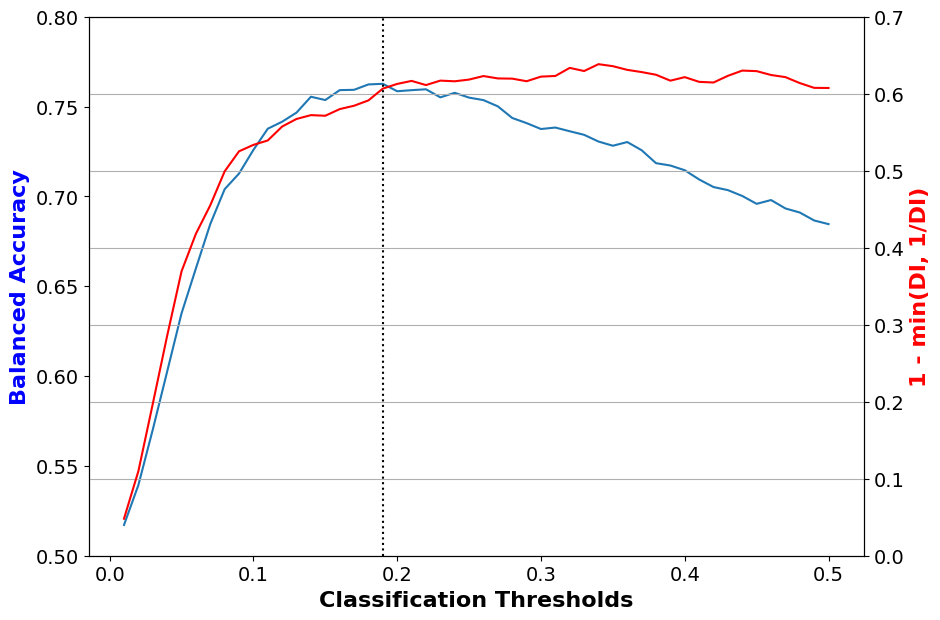

In [39]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

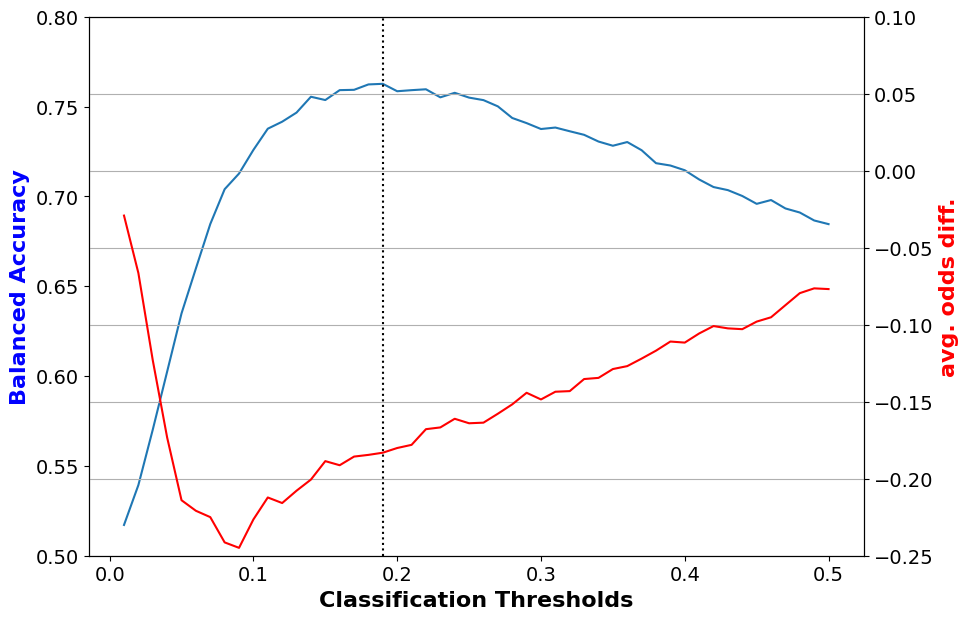

In [40]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

Make a function to print out accuracy and fairness metrics. This will be used throughout the tutorial.

In [41]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [42]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


#### 3.2.3. Testing LR model on original data

In [43]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [44]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, $\text{average odds difference} = \frac{(FPR_{unpriv}-FPR_{priv})+(TPR_{unpriv}-TPR_{priv})}{2}$ must be close to zero for the classifier to be fair.

Again, the results for this classifier-data combination are still high. This still implies unfairness.

#### 3.3. Learning a Random Forest (RF) classifier on original data

##### 3.3.1. Training RF model on original data

In [45]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 3.3.2. Validating RF model on original data

In [46]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

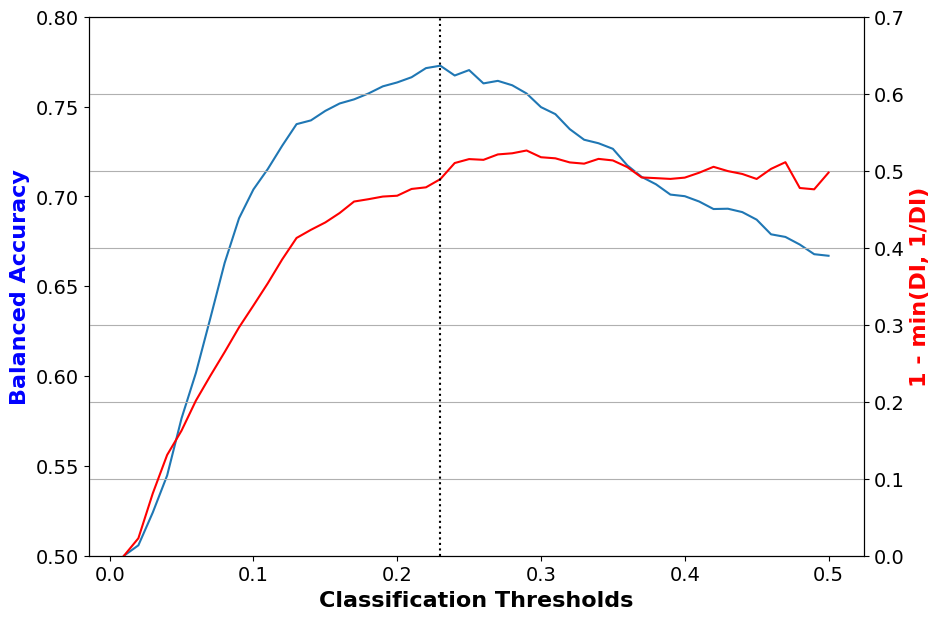

In [47]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

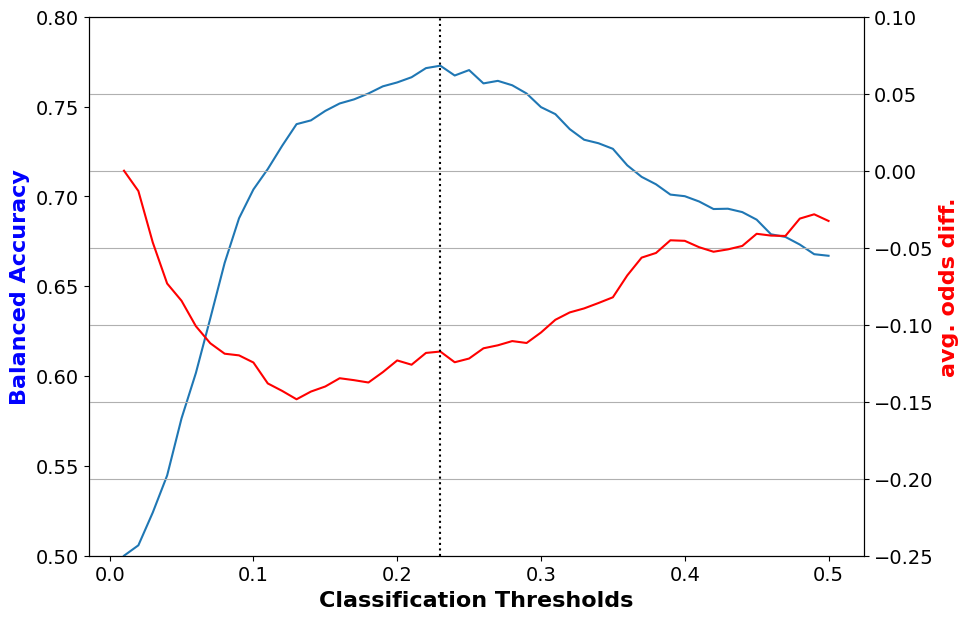

In [48]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [49]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7727
Corresponding 1-min(DI, 1/DI) value: 0.4891
Corresponding average odds difference value: -0.1174
Corresponding statistical parity difference value: -0.1952
Corresponding equal opportunity difference value: -0.1076
Corresponding Theil index value: 0.0893


#### 3.3.3. Testing RF model on original data

In [50]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [51]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7640
Corresponding 1-min(DI, 1/DI) value: 0.5040
Corresponding average odds difference value: -0.1346
Corresponding statistical parity difference value: -0.2121
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


### Section 3 Write Up here

### Part-01: For **both** the logistic regression and random forest classifiers learned on the original data, please include explain the results of your fairness metrics. For _each_ metric result briefly describe what this value means in 1-2 sentences (is it fair, is it not fair? Why?)

**Fairness Metric Summary**
* Threshold corresponding to Best balanced accuracy:
* Best balanced accuracy:
* Corresponding 1-min(DI, 1/DI) value:
* Corresponding average odds difference value:
* Corresponding statistical parity difference value:
* Corresponding equal opportunity difference value:
* Corresponding Theil index value:

### Part-02: Please write one paragraph for each question.
1. How can we determine which metrics to use, given our data and use case? You can refer to [Course material](https://nanrahman.github.io/capstone-responsible-ai/weeks/06-Fairness-Assessments/), online research and Guidance provided by [AIF360](http://aif360.mybluemix.net/resources#)
2. When you have competing fairness metrics, how to pick which to prioritize?
3. What do you do when you encounter different definitions for similar metrics?
4. Based on this, which model and fairness metric appears the best to proceed with?

For the logistic regression classifier trained on the original data, the best balanced accuracy was 0.7759 at a threshold of 0.19. The fairness metrics here show:
* **1 - min(DI, 1/DI)**: This metric scored 0.5738, which exceeds the <0.2 threshold typically indiciating fairness. This higher value implies that the model treats groups unequally, suggesting possible bias in predictions.
* **Average Odds Difference**: The metric value of -0.2057 points to an imbalance between false positive and true positive rates for different groups, indicating potential unfairness in classification outcomes.
* **Statistical Parity Difference**:** With a result of -0.2612, the model displays unequal outcome rates across groups, which points to a lack of parity in how outcomes are distributed.
* **Equal Opportunity Difference**: At -0.2288, this metrics shows differing true positive rates between groups, indicating unequal access to favorable predictions.
* **Theil Index**: the score of 0.0921 represents some inequality in benefit distribution across the dataset, considering that the model could be fairer.

For the random forest model, we achieved a balanced accuracy of 0.7640 at a threshold of 0.23. Here’s how each fairness metrics compares:
* **1 - min(DI, 1/DI)**’s value was 0.5040, which still misses the fairness target, though it’s slightly better than the logistics model.
* **Average Odds Difference** of -0.1346 indicates some imbalance in true and false positive rates between groups but less than with logistic regression.
* **Statistical Parity Difference** of -0.2121 shows that one group is receiving more favorable outcomes than the other.
* **Equal Opportunity Difference**: At -0.1141, this value is closer to fair but still suggests slight disparities in error rates between groups.
* **Theil Index**: At 0.0944, the result implies slight unfairness, as it indicates some inequality in how benefits are distributed across individuals. A lower score would suggest a fairer distribution where individuals receive similar levels of benefits.

We can determine what metrics to use based on the content and purpose of the MEPS database. Since this dataset pertains to healthcare and patient characteristics it would be important to determine metrics based on prominent factors such as age, race, gender, and other demographics. Based on these groups and other features such as diagnoses we can decide what fairness metrics to use to assure fair treatment across these groups and understand health trends among them for preventative care. If a group is being disproportionately affected by something, it is important that fairness metrics can quantify that unfairness in order to do some form of mitigation. An example would be disparate impact to check these fair outcomes. Another would be equal opportunity to monitor true positives across all groups, to ensure equality. This fits the given data and use case for this project. 

In this case if fairness metrics were in competition, we would have to prioritize the one that is more relevant to the healthcare industry. For example, the metrics mentioned above are high priority across all industries, but particularly for ensuring fairness across various demographics in healthcare. When it comes to ethics, these are major problems today in the industry that need to be combatted so people from all groups have equal opportunity and access to healthcare and that everyone is treated fairly in the system. For example, when it comes to healthcare a false negative in most cases can be a lot more harmful than a false negative since conditions and diseases can go untreated and be fatal. With things like this in mind, we can decide which fairness metrics to prioritize in this use case. 

In situations where we may encounter multiple metrics which appear to have similar definitions, we could start by looking at the mathematical definitions to determine specific differences in calculation. If any are identified, we can develop an understanding of how they affect the final resulting values produced by the metrics, and use that understanding to determine which one may be more appropriate to use in a given case. Additionally, we could do more research on the common use cases of the metrics to find where each one is more often used and try to understand the reasoning for each. From there, we could combine our mathematical and practical understanding of the metrics to decide which one or ones to use for our models.

The two models we tested were Logistic Regression classifier (LR) and Random Forest Classifier (RF). Using the unweighted original data, LR achieved a best balanced accuracy of 0.7759 compared to RF’s 0.7640, which is around a percent lower. Based on this alone, the LR model looks better. Looking at our fairness metrics, the LR model has a significantly lower threshold to best balanced accuracy at 0.19 compared to 0.23 for the RF model. LR has a higher 1-min(DI, 1/DI) value of 0.5738 compared to 0.5040 for RF. For average odds difference, statistical parity difference, and equal opportunity difference, LR has larger magnitude negative values than RF. Both models have similar values for Theil index. Overall, while LR achieves a slightly higher accuracy, it appears that the RF model performs better in terms of fairness, so it appears best to proceed with it.


### [4.](#Table-of-Contents) Additional Model Development

##### 4.1A Load data & create splits for learning/validating/testing model

In [52]:
# Use the same methods from Section 3
(dataset_orig_panel21_train,
 dataset_orig_panel21_val,
 dataset_orig_panel21_test) = MEPSDataset21().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel21_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel21_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel21_train.privileged_protected_attributes[sens_ind]]

#### 4.1B Utilize findings from your EDA to complete any additional model development

In [53]:
describe(dataset_orig_panel21_train, dataset_orig_panel21_val, dataset_orig_panel21_test)


#### Training Dataset shape

(7837, 138)


#### Validation Dataset shape

(4703, 138)


#### Test Dataset shape

(3135, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [54]:
metric_orig_panel21_train = BinaryLabelDatasetMetric(
        dataset_orig_panel21_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel21_train = MetricTextExplainer(metric_orig_panel21_train)

print(explainer_orig_panel21_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.4856132419740048


In [55]:
# Examples:

# Feature selection
# encoding
# binning categorical features

# Feel free to use the codebook from MEPS to explore other variables


### 4.2. Learning a Logistic Regression (LR) classifier on original data

In [56]:
# Use the same methods from Section 3
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

### 4.3. Learning a Random Forest (RF) classifier on original data

In [57]:
# Use the same methods from Section 3

### Section 4 Write Up here

**1. For both the logistic regression and random forest classifiers learned on the original data, please include the results of your fairness metrics. For _each_ metric result briefly describe (1-2 sentences) if you saw any differences from your results in Part 3, and what that might mean.**

_Fairness Metrics_
   * Threshold corresponding to Best balanced accuracy:
   * Best balanced accuracy:
   * Corresponding 1-min(DI, 1/DI) value:
   * Corresponding average odds difference value:
   * Corresponding statistical parity difference value:
   * Corresponding equal opportunity difference value:
   * Corresponding Theil index value:
    
**2. Based on this, would you make any recommendations during model development? Does it change which model and fairness metric would be the best to proceed with?** (Please write at least one paragraph)


### End of Replication Part 02 -  Model Development and Fairness Evaluation

----

## There are **two** components to `Replication Project Part #03`

### Part 1. Run the full tutorial example. Within AIF360's Repository it can be found under: `AIF360`/`Examples`/tutorial_medical_expenditure.ipynb

#### BEFORE YOU BEGIN MAKE SURE THAT:
* A reminder, you will need to fork [AIF360's repository](https://github.com/Trusted-AI/AIF360) into your own GitHub and access the notebook locally or via your method of choice
* AIF360's Repository can be found under: `AIF360`/`Examples`/tutorial_medical_expenditure.ipynb
* Ensure you have your `aif360` environment turned and activated using a miniconda prompt
* Use Jupyter Labs
* Refer to [Week 03](https://nanrahman.github.io/capstone-responsible-ai/weeks/03-Replication-Part-00/) content on the course Website to access the `Quickstart Guide`

#### FOR THE DATA
* Downloade the `h181.csv` and `h192.csv` data files uploaded [here](https://www.kaggle.com/datasets/nanrahman/mepsdata)
* Place the `h181.csv` and `h192.csv` ino `../aif360/data/raw/meps/` of your forked AIF360 repository

### Part 2. Training models WITH de-biasing, trying out another type of de-biasing method

*Below is a list of additional notebooks that demonstrate the use of AIF360*

* NEW: [sklearn/demo_new_features.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/sklearn/demo_new_features.ipynb): highlights the features of the new scikit-learn-compatible API
* [demo_optim_data_preproc.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb): demonstrates a generalization of the credit scoring tutorial that shows the full machine learning workflow for the optimized data pre-processing algorithm for bias mitigation on several datasets
* [demo_adversarial_debiasing.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_adversarial_debiasing.ipynb): demonstrates the use of the adversarial debiasing in-processing algorithm to learn a fair classifier
* [demo_calibrated_eqodds_postprocessing.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_calibrated_eqodds_postprocessing.ipynb): demonstrates the use of an odds-equalizing post-processing algorithm for bias mitigiation
* [demo_disparate_impact_remover.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb): demonstrates the use of a disparate impact remover pre-processing algorithm for bias mitigiation
* [demo_lfr.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_lfr.ipynb): demonstrates the use of the learning fair representations algorithm for bias mitigation
* [demo_lime.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_lime.ipynb): demonstrates how LIME - Local Interpretable Model-Agnostic Explanations - can be used with models learned with the AIF 360 toolkit to generate explanations for model predictions
* [demo_reject_option_classification.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_reject_option_classification.ipynb): demonstrates the use of the Reject Option Classification (ROC) post-processing algorithm for bias mitigation
* [demo_reweighing_preproc.ipynb](https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_reweighing_preproc.ipynb): demonstrates the use of a reweighing pre-processing algorithm for bias mitigation


### [5.](#Table-of-Contents) Bias Mitigation

### [5A.](#Table-of-Contents) Bias mitigation using pre-processing technique, Reweighing - AIF360 Example

In [58]:
# Follow the full AIF360 Example

### [5B.](#Table-of-Contents) Prejudice Remover (in-processing bias mitigation) -  AIF360 Example

In [59]:
# Follow the full AIF360 Example

### [5C.](#Table-of-Contents) Bias mitigation using a technique of your own


In [60]:
# Choose your own technique!

### [6.](#Table-of-Contents) Results Summary

### [7.](#Table-of-Contents) Explainability

### [8.](#Table-of-Contents) Conclusion & Discussion